**Description**

This notebook is created to understand how Deep Neural Networks (DNNs) can be used for image classification problems. Though this method is NOT RECOMMENDED, it is possible to use DNNs to classify images. 

**Dataset**

For the demo, the MNIST datasest will be used to train the DNN (this dataset is commonly used to train image processing systems).

MNIST is handwritten digits database, which contains large quantity of handwritten digits from 0 to 9. Each digit is in grayscale, so we will be dealing with a single channel images. Every image in the dataset is standardized to be 28 * 28 pixels, giving 784 pixels for each image. 

The MNIST handwritten digits dataset is available here:
http://yann.lecun.com/exdb/mnist and https://www.kaggle.com/datasets/oddrationale/mnist-in-csv

**Parameters Explosion:**
   - Consider a 100 * 100 pixel image (10,000 pixels per image) -->> the first layer will contain 10,000 neurons.
   - Interconnections between this layer and the next layer ~O(10,000 * 10,000)
   - Now, we would already have 100 million parameters to train a fully-connected neural network!
   - The time needed to train so many parameters will be huge
   
Thus, dense, fully connected neural networks can't really cope with image data.
Also, they do not provide feature extraction with locatin invariance. DNNs do not consider the spacial aspects of images. 

### Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

In [2]:
mnist_train = pd.read_csv('datasets/mnist-in-csv/mnist_train.csv')
mnist_test = pd.read_csv('datasets/mnist-in-csv/mnist_test.csv')

mnist_train.shape, mnist_test.shape

((60000, 785), (10000, 785))

In [3]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Let's have a look at one image from the dataset
img = mnist_train[1:2]
img = img.drop('label', axis=1)
img = img.values
img.shape

(1, 784)

In [5]:
# Reshape img to be a single-channeled image
img = img.reshape(1, 28, 28)
img.shape

(1, 28, 28)

In [6]:
img = img.squeeze() # quickly eliminating the dimension that just have single values
img.shape

(28, 28)

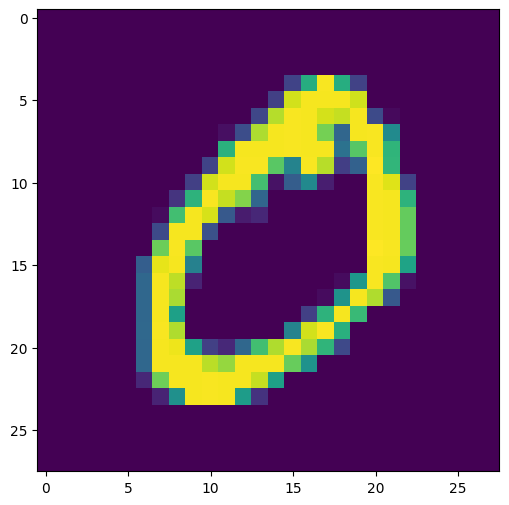

In [7]:
# Displaying the image with Matplotlib
plt.figure(figsize= (6, 6))
plt.imshow(img)
plt.show()

In [8]:
mnist_train = mnist_train.dropna()
mnist_test = mnist_test.dropna()

In [9]:
mnist_train_features = mnist_train.drop('label', axis=1)
mnist_train_target = mnist_train['label']

mnist_test_features = mnist_test.drop('label', axis=1)
mnist_test_target = mnist_test['label']

In [10]:
print("train max - ", mnist_train_features.values.max())
print("train min - ", mnist_train_features.values.min())
print("test max - ", mnist_test_features.values.max())
print("test min - ", mnist_test_features.values.min())

train max -  255
train min -  0
test max -  255
test min -  0


In [11]:
mnist_train_features = mnist_train_features.astype('float32')
mnist_train_features = mnist_train_features/255
mnist_test_features = mnist_test_features.astype('float32')
mnist_test_features = mnist_test_features/255

print("train max - ", mnist_train_features.values.max())
print("train min - ", mnist_train_features.values.min())
print("test max - ", mnist_test_features.values.max())
print("test min - ", mnist_test_features.values.min())

train max -  1.0
train min -  0.0
test max -  1.0
test min -  0.0


In [12]:
# Creating torch tensors that will be used in DNN training process
X_train_tensor = torch.tensor(mnist_train_features.values, dtype=torch.float)
X_test_tensor = torch.tensor(mnist_test_features.values, dtype=torch.float)

Y_train_tensor = torch.tensor(mnist_train_target.values, dtype=torch.long)
Y_test_tensor = torch.tensor(mnist_test_target.values, dtype=torch.long)

In [13]:
X_train_tensor.shape, Y_train_tensor.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [14]:
X_test_tensor.shape, Y_test_tensor.shape

(torch.Size([10000, 784]), torch.Size([10000]))

### Setting up a Fully Connected NN for image classification

In [15]:
import torch.nn as nn

In [16]:
input_size = 784
output_size = 10

hidden1_size = 16
hidden2_size = 32

In [17]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return torch.log_softmax(x, dim=-1)  # equivalent to log(softmax()) and used with NLLLoss function
                                             # stable numerically and has better performance

### Training the Fully Connected NN

In [18]:
model = Net()

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [21]:
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

In [22]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
epochs = 500

In [23]:
for epoch in range(1, epochs+1):
    
    optimizer.zero_grad()
    Y_pred = model(X_train_tensor)
    
    loss = loss_fn(Y_pred, Y_train_tensor)
    loss.backward() # compute gradients
    
    optimizer.step() # updating the model parameters
    
    if epoch % 10 ==0:
        print('Epoch - %d, loss - %0.2f ' %(epoch, loss.item()))

Epoch - 10, loss - 2.29 
Epoch - 20, loss - 2.27 
Epoch - 30, loss - 2.25 
Epoch - 40, loss - 2.22 
Epoch - 50, loss - 2.18 
Epoch - 60, loss - 2.13 
Epoch - 70, loss - 2.08 
Epoch - 80, loss - 2.02 
Epoch - 90, loss - 1.95 
Epoch - 100, loss - 1.88 
Epoch - 110, loss - 1.81 
Epoch - 120, loss - 1.74 
Epoch - 130, loss - 1.68 
Epoch - 140, loss - 1.61 
Epoch - 150, loss - 1.56 
Epoch - 160, loss - 1.50 
Epoch - 170, loss - 1.45 
Epoch - 180, loss - 1.40 
Epoch - 190, loss - 1.35 
Epoch - 200, loss - 1.30 
Epoch - 210, loss - 1.26 
Epoch - 220, loss - 1.22 
Epoch - 230, loss - 1.18 
Epoch - 240, loss - 1.14 
Epoch - 250, loss - 1.11 
Epoch - 260, loss - 1.08 
Epoch - 270, loss - 1.04 
Epoch - 280, loss - 1.02 
Epoch - 290, loss - 0.99 
Epoch - 300, loss - 0.96 
Epoch - 310, loss - 0.94 
Epoch - 320, loss - 0.91 
Epoch - 330, loss - 0.89 
Epoch - 340, loss - 0.87 
Epoch - 350, loss - 0.85 
Epoch - 360, loss - 0.83 
Epoch - 370, loss - 0.81 
Epoch - 380, loss - 0.79 
Epoch - 390, loss - 0

### Making predictions

In [24]:
model.eval() # layers and operations that should be applied only in training data (e.g. dropout and regularization)
             # will be truned off

Net(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [26]:
with torch.no_grad():
    correct = 0
    total = 0
    
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    Y_test = Y_test_tensor.cpu().numpy()
    predicted = predicted.cpu()
    
    print("Accuracy: ", accuracy_score(predicted, Y_test))
    print("Precision: ", precision_score(predicted, Y_test, average='weighted'))
    print("Recall: ", recall_score(predicted, Y_test, average='weighted'))

Accuracy:  0.8701
Precision:  0.8740288783074267
Recall:  0.8701
